In [16]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [17]:
#Default dimensions we found online
img_width, img_height = 224, 224 
 
#Create a bottleneck file
top_model_weights_path = 'bottleneck_fc_model.h5'
# loading up our datasets
train_data_dir = 'data/train' 
validation_data_dir = 'data/validation'
test_data_dir = 'data/test'
 
# number of epochs to train top model 
epochs = 7 #this has been changed after multiple model run 
# batch size used by flow_from_directory and predict_generator 
batch_size = 50 

In [64]:
#Loading vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 
#needed to create the bottleneck .npy files

In [24]:
start = datetime.datetime.now()
   
generator = datagen.flow_from_directory(  
     train_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_train_samples = len(generator.filenames)  
num_classes = len(generator.class_indices)  
   
predict_size_train = int(math.ceil(nb_train_samples / batch_size))  
   
bottleneck_features_train = vgg16.predict_generator(generator, predict_size_train)  
   
np.save('bottleneck_features_train.npy', bottleneck_features_train)
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3268 images belonging to 2 classes.
Time:  0:07:00.953328


In [25]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     validation_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_validation_samples = len(generator.filenames)  
   
predict_size_validation = int(math.ceil(nb_validation_samples / batch_size))  
   
bottleneck_features_validation = vgg16.predict_generator(  
     generator, predict_size_validation)  
   
np.save('bottleneck_features_validation.npy', bottleneck_features_validation) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 384 images belonging to 2 classes.
Time:  0:00:46.845669


In [26]:
start = datetime.datetime.now()
generator = datagen.flow_from_directory(  
     test_data_dir,  
     target_size=(img_width, img_height),  
     batch_size=batch_size,  
     class_mode=None,  
     shuffle=False)  
   
nb_test_samples = len(generator.filenames)  
   
predict_size_test = int(math.ceil(nb_test_samples / batch_size))  
   
bottleneck_features_test = vgg16.predict_generator(  
     generator, predict_size_test)  
   
np.save('bottleneck_features_test.npy', bottleneck_features_test) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 194 images belonging to 2 classes.
Time:  0:00:25.045678


In [27]:
start = datetime.datetime.now()
datagen_top = ImageDataGenerator(rescale=1./255)  
generator_top = datagen_top.flow_from_directory(  
         train_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode='categorical',  
         shuffle=False)  
   
nb_train_samples = len(generator_top.filenames)  
num_classes = len(generator_top.class_indices)  
   
# load the bottleneck features saved earlier  
train_data = np.load('bottleneck_features_train.npy')  
   
# get the class lebels for the training data, in the original order  
train_labels = generator_top.classes  
   
# convert the training labels to categorical vectors  
train_labels = to_categorical(train_labels, num_classes=num_classes) 
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Found 3268 images belonging to 2 classes.
Time:  0:00:00.439557


In [29]:
generator_top = datagen_top.flow_from_directory(  
         validation_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_validation_samples = len(generator_top.filenames)  
   
validation_data = np.load('bottleneck_features_validation.npy')  
   

validation_labels = generator_top.classes  
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 384 images belonging to 2 classes.


In [30]:
generator_top = datagen_top.flow_from_directory(  
         test_data_dir,  
         target_size=(img_width, img_height),  
         batch_size=batch_size,  
         class_mode=None,  
         shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   

test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 194 images belonging to 2 classes.


In [31]:
num_classes

2

In [32]:
train_data.shape

(3268, 7, 7, 512)

In [37]:
start = datetime.datetime.now()
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(num_classes, activation='softmax'))  

model.compile(optimizer='rmsprop',  
          loss='categorical_crossentropy', metrics=['accuracy'])  

history = model.fit(train_data, train_labels,  
      epochs=6,  
      batch_size=batch_size,  
      validation_data=(validation_data, validation_labels))

model.save_weights(top_model_weights_path)  

(eval_loss, eval_accuracy) = model.evaluate(  
 validation_data, validation_labels, batch_size=batch_size, verbose=1)

print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100))  
print("[INFO] Loss: {}".format(eval_loss))  
end= datetime.datetime.now()
elapsed= end-start
print ('Time: ', elapsed)

Epoch 1/6
66/66 [==============================] - 3s 49ms/step - loss: 1.5658 - accuracy: 0.8201 - val_loss: 0.4016 - val_accuracy: 0.8464
Epoch 2/6
66/66 [==============================] - 3s 44ms/step - loss: 0.1729 - accuracy: 0.9443 - val_loss: 0.0686 - val_accuracy: 0.9766
Epoch 3/6
66/66 [==============================] - 3s 43ms/step - loss: 0.1244 - accuracy: 0.9602 - val_loss: 0.0449 - val_accuracy: 0.9896
Epoch 4/6
66/66 [==============================] - 3s 43ms/step - loss: 0.0833 - accuracy: 0.9749 - val_loss: 0.0513 - val_accuracy: 0.9766
Epoch 5/6
66/66 [==============================] - 3s 44ms/step - loss: 0.0541 - accuracy: 0.9798 - val_loss: 0.1747 - val_accuracy: 0.9583
Epoch 6/6
8/8 [==============================] - 0s 5ms/step - loss: 0.0583 - accuracy: 0.9844
[INFO] accuracy: 98.44%
[INFO] Loss: 0.058333635330200195
Time:  0:00:18.834990


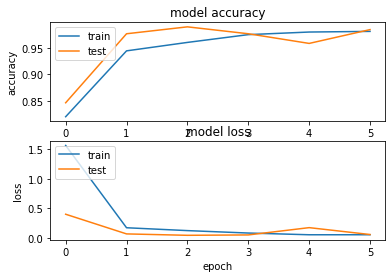

In [38]:
plt.figure(1)  

# summarize history for accuracy  

plt.subplot(211)  
plt.plot(history.history['accuracy'])  
plt.plot(history.history['val_accuracy'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  

# summarize history for loss  

plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()

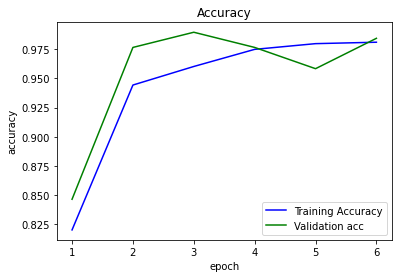

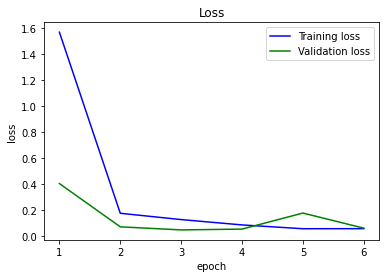

In [40]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epch = range(1, len(train_acc) + 1)
plt.plot(epch, train_acc, 'b', label='Training Accuracy')
plt.plot(epch, val_acc, 'g', label='Validation acc')
plt.title('Accuracy')
plt.ylabel('accuracy')  
plt.xlabel('epoch') 
plt.legend()
plt.figure()
plt.plot(epch, train_loss, 'b', label='Training loss')
plt.plot(epch, val_loss, 'g', label='Validation loss')
plt.title('Loss')
plt.ylabel('loss')  
plt.xlabel('epoch') 
plt.legend()
plt.show()

In [41]:
model.evaluate(test_data, test_labels)

7/7 [==============================] - 0s 5ms/step - loss: 0.0394 - accuracy: 0.9845


[0.03941386565566063, 0.9845361113548279]

In [68]:
preds = np.round(model.predict(test_data), 0)
# to fit them into classification metrics and confusion metrics, some additional modifications are required
print('rounded test_labels', preds)

rounded test_labels [[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]

In [70]:
categories = ['with_mask', 'without_mask']
classification_metrics = metrics.classification_report(test_labels, preds, target_names = categories)
print(classification_metrics)

              precision    recall  f1-score   support

   with_mask       1.00      0.97      0.98        97
without_mask       0.97      1.00      0.98        97

   micro avg       0.98      0.98      0.98       194
   macro avg       0.98      0.98      0.98       194
weighted avg       0.98      0.98      0.98       194
 samples avg       0.98      0.98      0.98       194



In [71]:
#Since our data is in dummy format we put the numpy array into a dataframe and call idxmax axis=1 to return the column
# label of the maximum value thus creating a categorical variable
#Basically, flipping a dummy variable back to it’s categorical variable
categorical_test_labels = pd.DataFrame(test_labels).idxmax(axis=1)
categorical_preds = pd.DataFrame(preds).idxmax(axis=1)
confusion_matrix= confusion_matrix(categorical_test_labels, categorical_preds)

#To get better visual of the confusion matrix:
def plot_confusion_matrix(cm, classes, normalize=False, 
                          title='Confusion matrix', cmap=plt.cm.Blues):
 
    # Add Normalization Option
    '''prints pretty confusion metric with normalization option'''
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print('Normalized confusion matrix')
    else:
        print('Confusion matrix, without normalization')
 
    # print(cm)
 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment='center', color='white' if cm[i, j] > thresh else 'black')
 
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label') 

Normalized confusion matrix


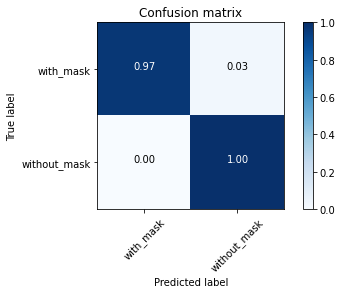

In [72]:
plot_confusion_matrix(confusion_matrix, ['with_mask', 'without_mask'], normalize=True)

[INFO] loading and preprocessing image…
ID: 0, Label: with_mask 100.0%
Final Decision:
ID: 1, Label: without_mask 0.0%
Final Decision:
.
..
...
ID: 0, Label: with_mask


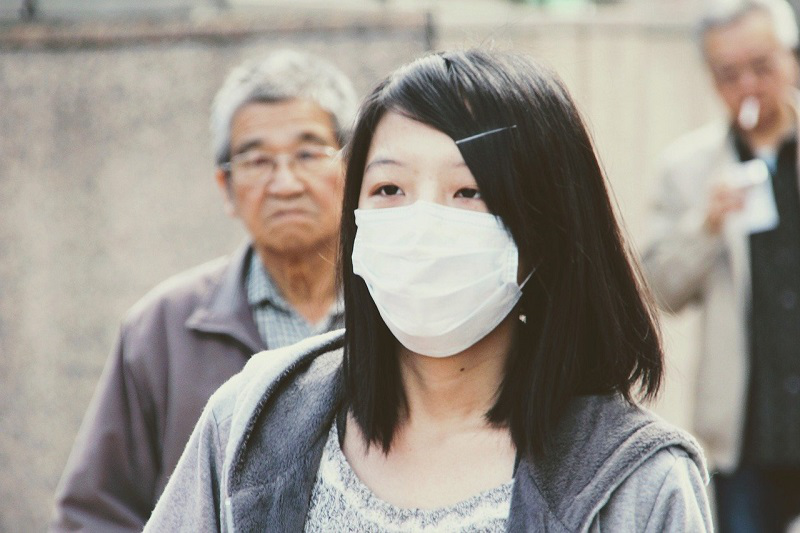

In [88]:
def read_image(file_path):
    print('[INFO] loading and preprocessing image…') 
    image = load_img(file_path, target_size=(224, 224)) 
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255. 
    return image

def test_single_image(path):
    categories = ['with_mask', 'without_mask']
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = vgg16.predict(images) 
    preds = model.predict_proba(bt_prediction)
    for idx, categ, x in zip(range(0,6), categories , preds[0]):
        print('ID: {}, Label: {} {}%'.format(idx, categ, round(x*100,2) ))
        print('Final Decision:')
        time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
        time.sleep(.2)
    class_predicted = np.argmax(model.predict(bt_prediction))
    class_dictionary = generator_top.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print('ID: {}, Label: {}'.format(class_predicted,  inv_map[class_predicted])) 
    return load_img(path)
path = 'data/test/fail.jpg'
test_single_image(path)